In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# model 관련

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# 다른 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import  KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

2022-08-16 04:21:17.937733: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-16 04:21:17.937761: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv('./creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [4]:
print('No Frauds', round(df['Class'].value_counts()[0] / len(df) *100,2), '%of the dataset')
print('Frauds', round(df['Class'].value_counts()[1] / len(df) *100,2), '%of the dataset')

No Frauds 99.83 %of the dataset
Frauds 0.17 %of the dataset


Text(0.5, 1.0, 'Class Distribution \n (0: No Fraud || 1:Fraud')

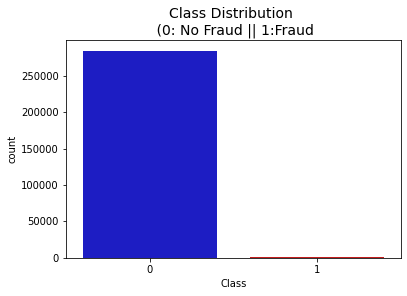

In [5]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distribution \n (0: No Fraud || 1:Fraud', fontsize=14)

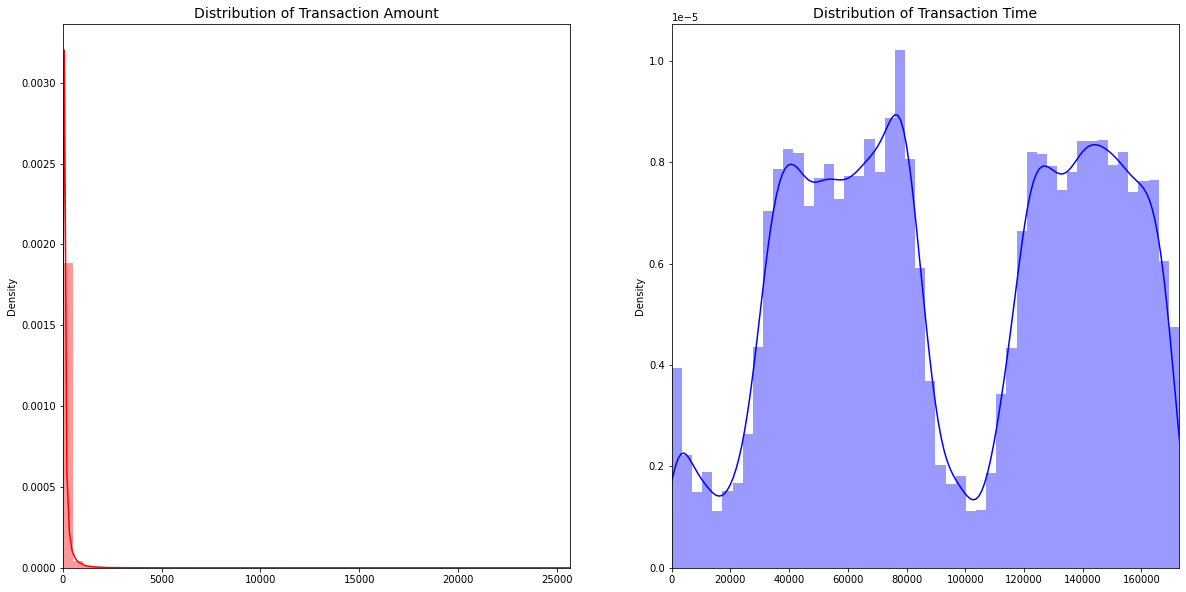

In [6]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

In [7]:
from sklearn.preprocessing import StandardScaler, RobustScaler
# RobustScaler 가 outlier 값에 덜 노출 된다.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# 기존 컬럼은 삭제
df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [8]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

# 다시 dataframe 정렬
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X,y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


In [10]:
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('-'*100)

print('Label Distributions: \n')
print(train_counts_label / len(original_ytrain))
print(test_counts_label / len(original_ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [11]:
df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df  = df.loc[df['Class'] == 0][:492]

normal_distributed_df= pd.concat([fraud_df, non_fraud_df])

new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
255862,0.111088,0.854615,2.062815,-0.265665,-1.974229,0.315056,0.384016,-0.764507,0.308437,-0.200309,...,-0.301131,-0.067431,-0.178136,0.086368,0.412184,0.137645,0.554409,-0.118727,-0.074097,0
108708,5.650807,-0.160469,-3.170818,0.185735,-3.399852,3.761155,-2.148047,-1.598944,-2.519565,1.316215,...,1.932254,1.092051,-0.041080,0.904395,0.180016,0.049970,-0.257100,0.859282,0.225924,1
272804,0.110948,0.946698,2.247162,-1.425105,-0.909591,-1.646274,-1.209057,-0.477864,-1.147420,-0.124056,...,-0.376320,-0.156509,0.022565,0.186260,-0.422858,-0.214952,-0.199197,0.010089,-0.059201,0
149577,-0.293440,0.080006,0.007379,2.365183,-2.600287,1.111602,3.276441,-1.776141,2.114531,-0.830084,...,-0.006388,-0.563944,-0.902100,-0.404382,-0.012944,0.589836,-0.734449,-0.447529,-0.362375,1
42945,-0.296793,-0.509686,-13.680760,6.990389,-13.770001,8.694897,-11.426968,-2.919845,-14.594562,8.622905,...,-0.877392,2.989553,0.497599,-0.509290,0.732503,0.280528,0.280037,-1.406687,-0.663643,1


Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


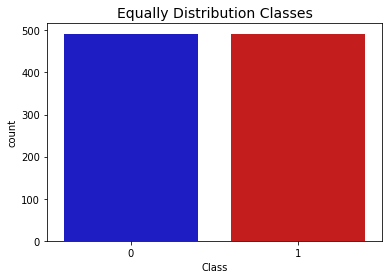

In [12]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distribution Classes', fontsize=14)
plt.show()

In [21]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1-t0))

# # PCA Implementation
# t0 = time.time()
# X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
# t1 = time.time()
# print("PCA took {:.2} s".format(t1-t0))

# # PCA Implementation
# t0 = time.time()
# X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
# t1 = time.time()
# print("Truncated SVD took {:.2} s".format(t1-t0))

T-SNE took 3.8 s


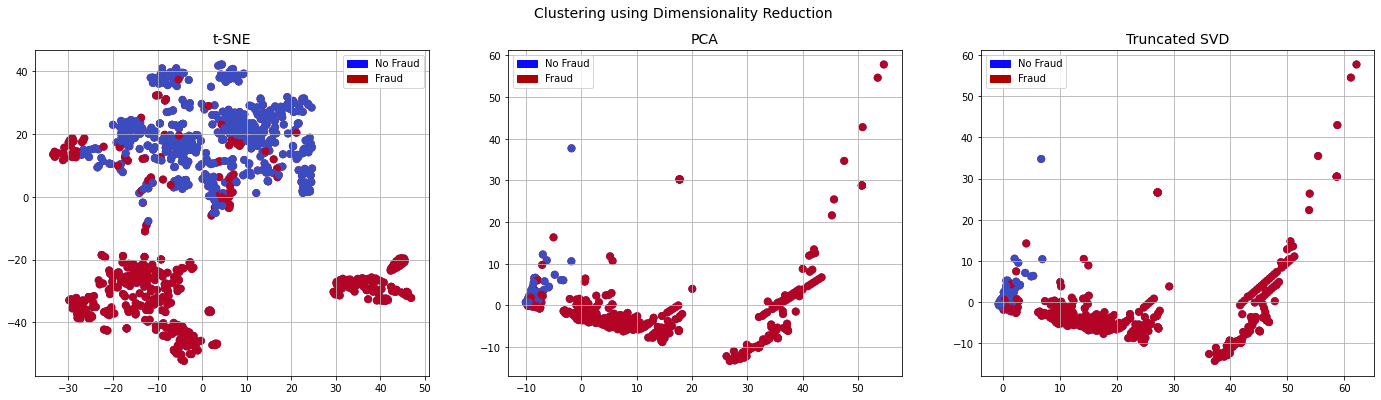

In [14]:
f, (ax1, ax2, ax3 ) = plt.subplots(1,3, figsize=(24,6))
f.suptitle('Clustering using Dimensionality Reduction', fontsize = 14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')
color_num = 2

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==0), cmap= plt.cm.coolwarm, label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==1), cmap= plt.cm.coolwarm, label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)
ax1.legend(handles =[blue_patch, red_patch])

# # PCA scatter plot
# ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y==0), cmap= plt.cm.coolwarm, label='No Fraud', linewidths=2)
# ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y==1), cmap=plt.cm.coolwarm, label='Fraud', linewidths=2)
# ax2.set_title('PCA', fontsize=14)

# ax2.grid(True)
# ax2.legend(handles =[blue_patch, red_patch])

# # TruncatedSVD scatter plot
# ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y==0), cmap= plt.cm.coolwarm, label='No Fraud', linewidths=2)
# ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y==1), cmap=plt.cm.coolwarm, label='Fraud', linewidths=2)
# ax3.set_title('Truncated SVD', fontsize=14)

# ax3.grid(True)
# ax3.legend(handles =[blue_patch, red_patch])

plt.show()